In [56]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Downloading the labeled and unlabeled data

#How to add the file to gdrive

1. Open the drive link shared
2. Click the three dots next to ***HV-AI-2025*** and select 'Make a copy'

DO NOT MANUALLY DOWNLOAD THE DATA.
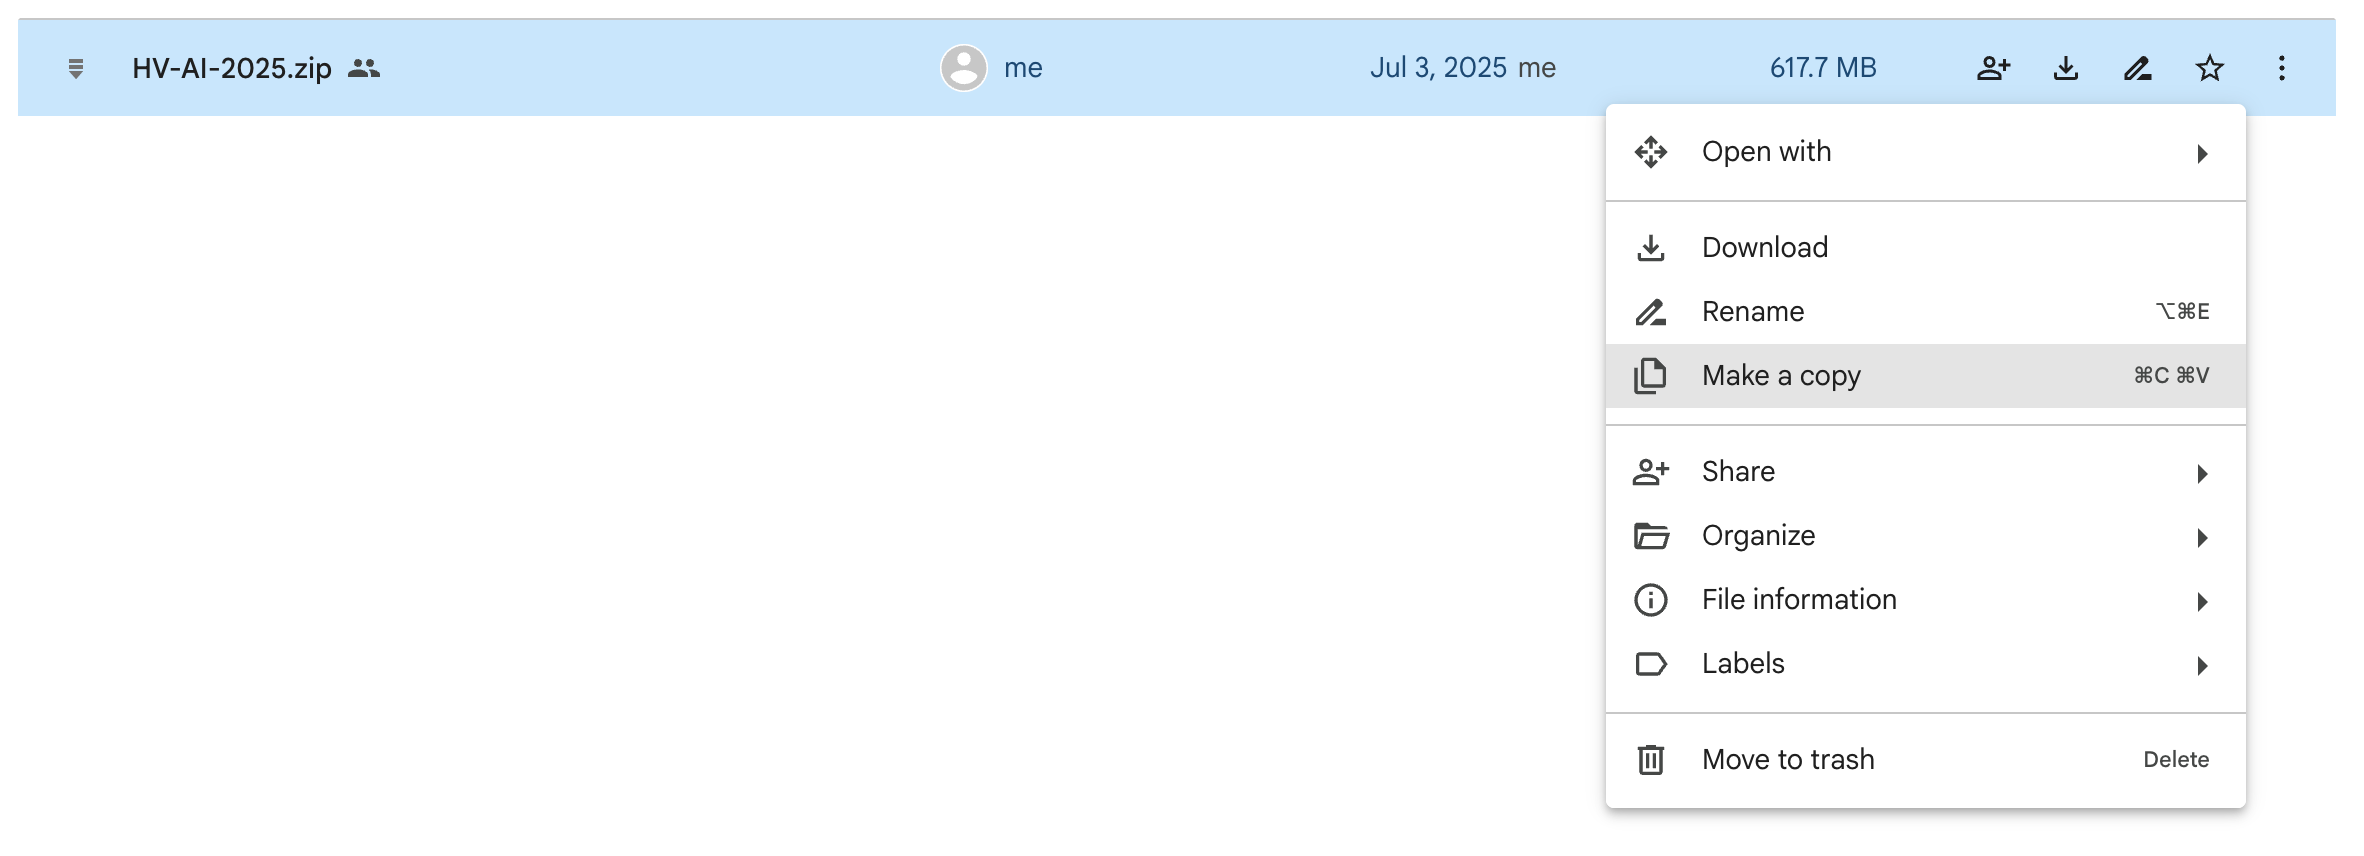

In [57]:
!cp "/content/drive/MyDrive/Copy of HV-AI-2025.zip" /content/HV-AI-2025.zip
!unzip HV-AI-2025.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2025/* /content/
!rm -rf /content/HV-AI-2025
!rm /content/HV-AI-2025.zip
!rm -rf /content/sample_data

# NOTE : "original_location_of_copy_in_drive" -> is a PLACEHOLDER. DO NOT RUN THIS AS IT IS.
# Please change this with your actual location/path where you have copied the data.
# Example, your path should look something like this -> "/content/drive/MyDrive/Copy of HV-AI-2025.zip"

Streaming output truncated to the last 5000 lines.
  inflating: HV-AI-2025/unlabeled_data/images/OIP-4t4U7LOzS-GByUxY_8ylMwHaFf.jpeg  
  inflating: HV-AI-2025/unlabeled_data/images/OIP-6Te7FgW0INPUUNl32tgW1QHaHa.jpeg  
  inflating: HV-AI-2025/unlabeled_data/images/921.jpeg  
  inflating: HV-AI-2025/unlabeled_data/images/OIP-7z-PsChIDdT8KECFqWQCRwHaEr.jpeg  
  inflating: HV-AI-2025/unlabeled_data/images/OIP-CE_0FI0DXtkH3rmQt4OiyAHaE7.jpeg  
  inflating: HV-AI-2025/unlabeled_data/images/OIP-RsoOv56vjNaHJcERlx21SwHaHv.jpeg  
  inflating: HV-AI-2025/unlabeled_data/images/ea37b80e2ef5023ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg  
  inflating: HV-AI-2025/unlabeled_data/images/OIP-LiaYVqnIYT9kpq_TwYmKJQHaF_.jpeg  
  inflating: HV-AI-2025/unlabeled_data/images/OIP-njs-RicCRdYTzNrlo4MoawHaH6.jpeg  
  inflating: HV-AI-2025/unlabeled_data/images/OIP-mQZ_kJuT8tsVsMSqXaRIOwHaHa.jpeg  
  inflating: HV-AI-2025/unlabeled_data/images/OIP-Tx86JrsI9viv15xZNvGgoQHaFj.jpeg  
  inflating: HV

# **Load/Preprocess **data****

In [58]:
!pip install optuna


In [59]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import optuna


# ImageNet normalization values for pretrained ResNet-18
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])



In [60]:
# Dataset class as before
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, label_map=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        if label_map is None:
            unique_labels = self.data_frame['label'].unique()
            self.label_map = {label: idx for idx, label in enumerate(sorted(unique_labels))}
        else:
            self.label_map = label_map

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.loc[idx, "img_name"])
        image = Image.open(img_name).convert('RGB')
        label_str = self.data_frame.loc[idx, "label"]
        label = self.label_map[label_str]
        if self.transform:
            image = self.transform(image)
        return image, label

In [61]:
import pandas as pd
csv_file = 'labeled_data/labeled_data.csv'
df = pd.read_csv(csv_file)
print(df.columns)
print(df.head())


Index(['img_name', 'label'], dtype='object')
                              img_name label
0  OIP--khXa4p9B3QV8JmsHX29hgHaEK.jpeg  cane
1  OIP--winA9MguCMZn6fdverPlwHaEK.jpeg  cane
2  OIP-0M8AAbNON2zvyCEB2WEhLQHaE8.jpeg  cane
3  OIP-16Mqc38MKBFr4a33cb_dFwHaGO.jpeg  cane
4  OIP-2sIPje3EMq9bP0vV2OGfmwHaEG.jpeg  cane


In [62]:
# Validation subset class that reloads image to avoid double transformation
class ValSubset(Dataset):
    def __init__(self, csv_file, root_dir, indices, label_map, val_transform):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.indices = indices
        self.label_map = label_map
        self.val_transform = val_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img_path = os.path.join(self.root_dir, self.data_frame.loc[real_idx, "img_name"])
        label_str = self.data_frame.loc[real_idx, "label"]
        label = self.label_map[label_str]

        image = Image.open(img_path).convert('RGB')
        if self.val_transform:
            image = self.val_transform(image)
        return image, label


In [63]:
# Paths (update to your environment)
csv_file = 'labeled_data/labeled_data.csv'
image_dir = 'labeled_data/images'

# Create full dataset with training transforms
full_dataset = CustomImageDataset(csv_file=csv_file, root_dir=image_dir, transform=train_transforms)
label_map = full_dataset.label_map

# Create stratified train/val split indices
train_idx, val_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    stratify=[full_dataset.data_frame.loc[i, "label"] for i in range(len(full_dataset))],
    random_state=42
)

# Subsets for train and val
train_dataset = Subset(full_dataset, train_idx)
val_dataset = ValSubset(csv_file, image_dir, val_idx, label_map, val_transforms)


In [64]:
# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **Model initialization/Training**

In [65]:
# Objective function for Optuna hyperparameter tuning
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])

    # Prepare model
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(label_map))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    # Train for 1 epoch (for faster tuning)
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy



In [66]:
# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-09-04 07:55:59,739] A new study created in memory with name: no-name-ab83117a-26fd-4496-846b-dc16ac7ddcf4
/tmp/ipython-input-2684692221.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/tmp/ipython-input-2684692221.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_util

Best trial:
  Accuracy: 0.8141025641025641
  Params: 
    lr: 0.0025338409603425146
    weight_decay: 0.00015046601414867068
    optimizer: SGD


In [67]:
# Assuming `study.best_trial.params` contains best hyperparameters
best_params = study.best_trial.params
best_lr = best_params['lr']
best_wd = best_params['weight_decay']
best_optimizer = best_params['optimizer']

# Create full dataset with training transforms
full_dataset = CustomImageDataset(csv_file=csv_file, root_dir=image_dir, transform=train_transforms)

# DataLoader for full dataset (no shuffle needed unless you want random batches)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(label_map))
model = model.to(device)

criterion = nn.CrossEntropyLoss()

if best_optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
else:
    optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9, weight_decay=best_wd)

# Number of epochs for final training
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in full_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(full_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

# Save final model for inference or Phase 1 submission
torch.save(model.state_dict(), "resnet18_final.pth")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 - Loss: 1.6915
Epoch 2/50 - Loss: 0.5826
Epoch 3/50 - Loss: 0.3436
Epoch 4/50 - Loss: 0.2126
Epoch 5/50 - Loss: 0.1757
Epoch 6/50 - Loss: 0.1204
Epoch 7/50 - Loss: 0.0929
Epoch 8/50 - Loss: 0.0624
Epoch 9/50 - Loss: 0.0642
Epoch 10/50 - Loss: 0.0505
Epoch 11/50 - Loss: 0.0326
Epoch 12/50 - Loss: 0.0301
Epoch 13/50 - Loss: 0.0187
Epoch 14/50 - Loss: 0.0252
Epoch 15/50 - Loss: 0.0230
Epoch 16/50 - Loss: 0.0230
Epoch 17/50 - Loss: 0.0214
Epoch 18/50 - Loss: 0.0281
Epoch 19/50 - Loss: 0.0245
Epoch 20/50 - Loss: 0.0193
Epoch 21/50 - Loss: 0.0172
Epoch 22/50 - Loss: 0.0104
Epoch 23/50 - Loss: 0.0102
Epoch 24/50 - Loss: 0.0123
Epoch 25/50 - Loss: 0.0114
Epoch 26/50 - Loss: 0.0143
Epoch 27/50 - Loss: 0.0114
Epoch 28/50 - Loss: 0.0104
Epoch 29/50 - Loss: 0.0127
Epoch 30/50 - Loss: 0.0147
Epoch 31/50 - Loss: 0.0068
Epoch 32/50 - Loss: 0.0133
Epoch 33/50 - Loss: 0.0101
Epoch 34/50 - Loss: 0.0094
Epoch 35/50 - Loss: 0.0054
Epoch 36/50 - Loss: 0.0062
Epoch 37/50 - Loss: 0.0049
Epoch 38/5

# **Model Inference**

In [68]:
!cp "/content/drive/MyDrive/Copy of HV-AI-2025-Test.zip" /content/HV-AI-2025-Test.zip
!unzip HV-AI-2025-Test.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2025-Test/* /content/
!rm -rf /content/HV-AI-2025-Test
!rm /content/HV-AI-2025-Test.zip
!rm -rf /content/sample_data

# NOTE : "original_location_of_copy_in_drive" -> is a PLACEHOLDER. DO NOT RUN THIS AS IT IS.
# Please change this with your actual location/path where you have copied the data.
# Example, your path should look something like this -> "/content/drive/MyDrive/Copy of HV-AI-2025-Test.zip"

Streaming output truncated to the last 5000 lines.
  inflating: HV-AI-2025-Test/test_images/OIP-YzZWlCiYdyG6V0W0BZyZQAHaLJ.jpeg  
  inflating: HV-AI-2025-Test/test_images/OIP-ADJJeiBee8FJRpVqBoYOAAHaE8.jpeg  
  inflating: HV-AI-2025-Test/test_images/OIP-rezzMoaidVH_SiLTrKg21wHaGU.jpeg  
  inflating: HV-AI-2025-Test/test_images/OIP-pibNhK8eu_PuwTuJzA6SngHaFj.jpeg  
  inflating: HV-AI-2025-Test/test_images/OIP-aNtiDa__wQpbA5Saz4x4VAHaE8.jpeg  
  inflating: HV-AI-2025-Test/test_images/OIP-8PmnmK7F_vrfXwdo1ERnxAHaFj.jpeg  
  inflating: HV-AI-2025-Test/test_images/OIP-HJH1KvHRZ5-CtV2QQX4urwHaGU.jpeg  
  inflating: HV-AI-2025-Test/test_images/OIP-Kga1Rhhp0w_oNB0fhZrVFAAAAA.jpeg  
  inflating: HV-AI-2025-Test/test_images/ea37b0082bf0093ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg  
  inflating: HV-AI-2025-Test/test_images/OIP-lOLq2CJuOb2c4ECrAVkFGwHaE0.jpeg  
  inflating: HV-AI-2025-Test/test_images/OIP-dFLMSWh7MTfPOpJ_b3kn9gHaFj.jpeg  
  inflating: HV-AI-2025-Test/test_images/OI

In [69]:
import os
from PIL import Image
import pandas as pd
import torch
import torchvision.transforms as transforms

# Paths
test_image_dir =  'test_images' # Folder containing test images
submission_csv = 'phase1_predictions.csv'  # Submission CSV filename

# Transformations for test images - same as validation (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load your trained model
model.eval()
model.to(device)

# Map integer outputs back to original string labels
inv_label_map = {v: k for k, v in label_map.items()}

# Read all test image filenames
test_images = sorted(os.listdir(test_image_dir))

predictions = []
with torch.no_grad():
    for img_name in test_images:
        img_path = os.path.join(test_image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        image = test_transforms(image).unsqueeze(0).to(device)  # Add batch dimension

        outputs = model(image)
        _, pred_idx = torch.max(outputs, 1)
        pred_label = inv_label_map[pred_idx.item()]

        predictions.append({'path': img_name, 'predicted_label': pred_label})



In [70]:
df_submission = pd.DataFrame(predictions)
df_submission.head()

,path,predicted_label
0,0_1034.jpeg,gatto
1,0_1045.jpeg,gatto
2,0_1085.jpeg,gatto
3,0_110.jpeg,ragno
4,0_1104.jpeg,gatto


In [71]:
# Save predictions to CSV for submission
df_submission.to_csv(submission_csv, index=False)

print(f"Saved predictions for {len(test_images)} test images to {submission_csv}")


Saved predictions for 10477 test images to phase1_predictions.csv


# **Helper Functions**

In [72]:
import requests

def send_results_for_evaluation(name, csv_file, email):
    url = "http://43.205.49.236:5050/inference"
    files = {'file': open(csv_file, 'rb')}
    data = {'email': email, 'name':name}
    response = requests.post(url, files=files, data=data)
    return response.json()



# ***Test Inference***


This function is used to save the csv file and send it to the evaluation server.

Format of CSV file (Follow the header names strictly):

          path (str)               predicted_label(str)
    test_data/images/xx.jpg               class_1         
    test_data/images/yy.jpg               class_2         
             :                               :                          
             :                               :                          

Once the prediction file is saved as shown in the above format, you can send it to the evaluation server along with your email.

Caution: check your **email** before executing the cell.

IMPORTANT NOTE: "class_1", "class_2" are just placeholders. They are not actual class names. Replace them with actual class names.


In [73]:
print('Accuracy: ')
print(send_results_for_evaluation('Guha Pranav Yelchuru', 'phase1_predictions.csv', 'yg.pranav@gmail.com'))

Accuracy: 
{'accuracy': 60.13}
